In [1]:
import pandas as pd
import copy
import math
import random
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

In [2]:
PASSWORD = "bridport20"
p = 0.70
ZVAL = norm.ppf(p/2 + 0.5)
c = 0.1

In [3]:
class EntryDivider:
    """
    Separates and cleans each entry from person's dataset
    """
    
    def __init__(self, df):
        self.df = df
        self.nr_entries = self.df["entry"].max() + 1
        self.entries = self.divide_entries()
        
    def divide_entries(self):
        """
        Separates each entry from person's dataset
        """
        entries = []
        for entry_i in range(self.nr_entries):
            curr_entry = self.df[self.df["entry"] == entry_i]
            curr_entry = self._reset_time(curr_entry.sort_values(by = ["time"]).reset_index(drop = True))
            curr_entry, is_still_clean = self._remove_faulty(curr_entry)
            if (is_still_clean and self._is_correct(curr_entry)):
                entries.append(curr_entry)
            #else:
               # print("not clean data, entry = ", entry_i)
            
        return entries
    
    def _reset_time(self, entry):
        """
        Resets times of the entry to their relative times
        """
        start_time = entry["time"].min()
        entry["time"] -= start_time
        
        return entry
    
    def _remove_faulty(self, entry):
        """
        Checks if entry doesnt have any other pressed keys
        """
        clean_entry = copy.deepcopy(entry)
        
        for key_char in list(clean_entry["key_char"]):
            if (not key_char in PASSWORD):
                return clean_entry, False
        return clean_entry, True
    
    def _is_correct(self, entry):
        """
        Checks if entry corresponds to password
        """
        clean_entry = entry[entry["event"] == "KeyPress"]
        clean_entry = clean_entry.sort_values(by = ["time"]).reset_index(drop = True)
        entered_text = "".join(list(clean_entry["key_char"]))
        return entered_text == PASSWORD
    

In [4]:
class EventTransformer:
    """
    Detects and removes outliers from a specific person
    """
    
    def __init__(self, entries): #[DataFrame]
        self.original_entries = entries
        self.transformed_entries = self.transform_data()

    
    def transform_data(self):
        """
        Transforms entries
        """
        entries = copy.deepcopy(self.original_entries)
        
        for entry_i in range(len(entries)):
            entries[entry_i] = entries[entry_i].sort_values(by = ["key_char", "time"]).reset_index(drop = True)
            
            for event_i in range(len(entries[entry_i])):
                entries[entry_i].loc[event_i, "time"] = self._transform(entries[entry_i].loc[event_i, "time"])
                
        return entries  
    
    
    def _transform(self, time):
        return math.log(time + 0.01)

In [5]:
class FeatureConstructor:
    
    def __init__(self, check_entry):
        self.check_entry = check_entry
        self.presstimes = self._get_presstimes()
        self.between_keypresses = self._get_between_keypresses()
        
    
    def _get_presstimes(self):
        """
        Calculates the time each key was pressed
        """
        entry = copy.deepcopy(self.check_entry)
        entry = entry.sort_values(by = ["key_char", "time"]).reset_index(drop = True)
        
        if (len(entry) % 2 != 0):
            print("we've got uneven pressing/releasing for some reason \n")
            return
        
        elapsed_times = {}
        sorted_password = ''.join(sorted(PASSWORD))
        for i in range(len(PASSWORD)):
            elapsed_times[self._key_index(i, sorted_password[i])] = []
            
        for event_i in range(0, len(entry)-1, 2):
            elapsed_time = entry.iloc[event_i+1]["time"] - entry.iloc[event_i]["time"]
            curr_key_char = entry.iloc[event_i]["key_char"]
            elapsed_times[self._key_index((event_i+1)//2, curr_key_char)] = elapsed_time
            
        return elapsed_times
        
        
    def _get_between_keypresses(self):
        """
        Calculate times between key presses
        """
        entry = copy.deepcopy(self.check_entry)
        entry = entry[entry["event"] == "KeyPress"].sort_values(by = ["time"]).reset_index(drop = True)
        
        between_times = {}
        
        for i in range(len(PASSWORD)-1):
            between_times[self._key_index(i, PASSWORD[i] + "->" + PASSWORD[i+1])] = [] 
            
        for event_i in range(len(entry)-1):
            between_time = entry.loc[event_i+1, "time"] - entry.loc[event_i, "time"]
            curr_key_char1 = entry.iloc[event_i]["key_char"]
            curr_key_char2 = entry.iloc[event_i+1]["key_char"]
            between_times[self._key_index(event_i, curr_key_char1 + "->" + curr_key_char2)] = between_time
            
        return between_times
        
        
    def _key_index(self, index, char):
        return str(index) + ": " + char

In [6]:
class OwnerData:
    
    def __init__(self, distributions):
        self.distributions = distributions
        self.stats_presstimes = self._get_presstimes()
        self.stats_between_keypresses = self._get_between_keypresses()
        self.threshold = self._calculate_threshold()
        
    def _get_presstimes(self):
        data = self.distributions[OWNER_NAME]
        data = data.drop(data.index[0]).dropna().to_dict()
        return self._float_convert(data)
    
    def _get_between_keypresses(self):
        data = self.distributions[OWNER_NAME+".1"]
        data = data.drop(data.index[0]).dropna().to_dict()
        return self._float_convert(data)
    
    def _float_convert(self, d):
        for key, arr in d.items():
            arr_strs = list(arr[1:-1].split(", "))
            d[key] = [float(nr) for nr in arr_strs]
        return d
    
    def _calculate_threshold_from_features(self, features_dict):
        threshold = 0
        for key, arr in features_dict.items():
            weight, std = arr[0], arr[2]
            new_thres = weight / ((ZVAL * std) + c)
            #print("weight = ", weight)
            #print("new_thres = ", new_thres)
            threshold += new_thres
        return threshold
            
    def _calculate_threshold(self):
        return self._calculate_threshold_from_features(self.stats_presstimes) + self._calculate_threshold_from_features(self.stats_between_keypresses)
            
            
        

In [7]:
class ScoreCalculator:
    """
    Calculates the score
    """
    
    def __init__(self, 
                 stats_presstimes, stats_between_keypresses, 
                 check_presstimes, check_between_keypresses):
        
        self.stats_presstimes = stats_presstimes
        self.stats_between_keypresses = stats_between_keypresses
        self.check_presstimes = check_presstimes
        self.check_between_keypresses = check_between_keypresses
        
        self.score = self.calculate_score()
        
    def calculate_score(self):
        return self._get_presstimes_score() + self._get_between_keypresses_score()
        
    def _get_presstimes_score(self):
        
        score = 0
        
        for key, point in self.check_presstimes.items():
            weight = self.stats_presstimes[key][0]
            mean = self.stats_presstimes[key][1]
            std = self.stats_presstimes[key][2]
            score += (weight / self._get_distance(mean, point))
            
        return score
    
    def _get_between_keypresses_score(self):
        
        score = 0
        
        for key, point in self.check_between_keypresses.items():
            weight = self.stats_between_keypresses[key][0]
            mean = self.stats_between_keypresses[key][1]
            std = self.stats_between_keypresses[key][2]
            score += (weight / self._get_distance(mean, point))
            
        return score
        
    def _get_distance(self, mean, point):
        return abs(point - mean) + c
          

In [8]:
names = []
names.append("Person1")
names.append("Person2")
names.append("Person3")
names.append("Person4")
names.append("Person5")

def get_len_train_entries_of(name):
    """
    Gets the number of entries from a processing dataset
    """
    name_entries_len = EntryDivider(pd.read_excel(name + ".xlsx", encoding = "utf8")).entries
    name_entries_len = EventTransformer(name_entries_len).transformed_entries
    return (len(name_entries_len))

def generate_entries_of(name):
    """
    Generating entries from all datasets
    """
    name_entries = EntryDivider(pd.read_excel("check " + name + ".xlsx", encoding = "utf8")).entries
    name_entries = EventTransformer(name_entries).transformed_entries
            
    return name_entries

nr_entries = {}
for name in names:
    nr_entries[name] = get_len_train_entries_of(name)  

In [9]:
def get_random_entry():
    name = random.choice(names)
    name_entries = generate_entries_of(name)
    check_entry_i = random.randrange(0, len(name_entries))
    check_entry = name_entries[check_entry_i]
    
    print("checking entry {} of {}".format(check_entry_i, name))
    
    return check_entry

In [10]:
""" Checking everybody against everybody """
acceptance_rates = {}
distributions_df = pd.read_csv("distributions.csv", encoding = "utf8", index_col = [0]) 

for owner_name in names:
    OWNER_NAME = owner_name
       
    owner_data = OwnerData(distributions_df)
    threshold = owner_data.threshold
    
    print("********************\n", "owner name =", OWNER_NAME, ", threshold =", threshold, "\n")
    
    for check_name in names:
        name_entries = generate_entries_of(check_name)
        print("\nchecking name = ", check_name)
        
        name_nr_train_entries = get_len_train_entries_of(check_name)
        # HERE IS THE COUNT: name_nr_train_entries
        
        pass_times = 0
        for entry_i in range(len(name_entries)):
            check_entry = name_entries[entry_i]
            
            check_features = FeatureConstructor(check_entry)
            score = ScoreCalculator(owner_data.stats_presstimes, owner_data.stats_between_keypresses,
                            check_features.presstimes, check_features.between_keypresses).score
            
            is_passed = score >= threshold
            #print("entry {:3}: score = {:20}, pass = {}".format(entry_i, score, is_passed))
            
            pass_times += 1 if (is_passed) else 0
            
            
        pass_rate = pass_times / len(name_entries) 
        if pass_rate > 0.5:
            acceptance_rates[check_name] = pass_rate 
            
        print("nr passes =", pass_times, "/", len(name_entries), "; pass rate =", pass_rate)
    
    print()
        
print(acceptance_rates)
                

********************
 owner name = Person1 , threshold = 300.8356171966375 


checking name =  Person1
nr passes = 65 / 70 ; pass rate = 0.9285714285714286

checking name =  Person2
nr passes = 0 / 70 ; pass rate = 0.0

checking name =  Person3
nr passes = 0 / 70 ; pass rate = 0.0

checking name =  Person4
nr passes = 0 / 70 ; pass rate = 0.0

checking name =  Person5
nr passes = 0 / 70 ; pass rate = 0.0

********************
 owner name = Person2 , threshold = 675.0494417466992 


checking name =  Person1
nr passes = 0 / 70 ; pass rate = 0.0

checking name =  Person2
nr passes = 67 / 70 ; pass rate = 0.9571428571428572

checking name =  Person3
nr passes = 0 / 70 ; pass rate = 0.0

checking name =  Person4
nr passes = 0 / 70 ; pass rate = 0.0

checking name =  Person5
nr passes = 0 / 70 ; pass rate = 0.0

********************
 owner name = Person3 , threshold = 320.2420332443555 


checking name =  Person1
nr passes = 0 / 70 ; pass rate = 0.0

checking name =  Person2
nr passes = 0 / 

In [11]:
print(acceptance_rates,
nr_entries)

{'Person1': 0.9285714285714286, 'Person2': 0.9571428571428572, 'Person3': 0.8571428571428571, 'Person4': 0.7285714285714285, 'Person5': 0.7142857142857143} {'Person1': 280, 'Person2': 596, 'Person3': 559, 'Person4': 140, 'Person5': 245}


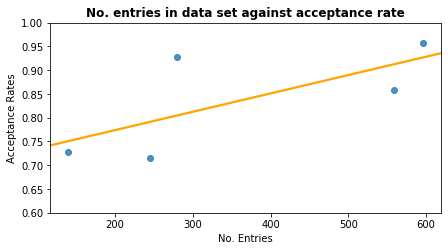

In [12]:
x = list(nr_entries.values())
y = list(acceptance_rates.values())
         

fig, ax = plt.subplots(figsize = (7,3.5))


sns.regplot(x, y, line_kws ={'color': 'orange'}, ci=None)

ax.set_title('No. entries in data set against acceptance rate', weight = 'bold')
ax.set_xlabel('No. Entries')
ax.set_ylabel('Acceptance Rates')
ax.set_ylim(0.6,1)

fig.savefig("pass_rates_entries.pdf");